<a href="https://colab.research.google.com/github/prateekgulati/EIP/blob/master/Session5/EIP_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, merge, Activation, ZeroPadding2D, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, GlobalMaxPooling2D
from keras.regularizers import l2
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys
% matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Mount Google Drive

In [3]:
# Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Load Dataset

In [4]:
!git clone "https://github.com/bckenstler/CLR.git"
from CLR.clr_callback import *
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (86/86), done.
--2019-06-30 10:29:27--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.4MB/s    in 18s     

2019-06-30 10:29:45 (12.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)

### Hyperparameters

In [0]:
# Hyperparameters
batch_size = 320
num_classes = 200
epochs = 100
l = 3
num_filter = 128
compression = 1.0
dropout_rate = 0.0
target_size=(32,32)

### Image Augmentation from imgaug

In [0]:
from imgaug import augmenters as iaa

augSeq = iaa.Sequential([
            iaa.Fliplr(0.25),
#             iaa.Flipud(0.25),   # Didn't help
            iaa.Sometimes(0.25, iaa.Affine(rotate=(-25, 25))),
            iaa.Sometimes(0.2, iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})),
            iaa.Sometimes(0.2, iaa.Crop(percent=(0, 0.125))),
            iaa.Sometimes(0.2, iaa.OneOf([
              iaa.CoarseDropout(0.2, size_percent=(0.05, 0.1)),
              iaa.CoarseSalt(0.2, size_percent=(0.05, 0.1)),
              iaa.CoarsePepper(0.2, size_percent=(0.05, 0.1)),
              iaa.CoarseSaltAndPepper(0.2, size_percent=(0.05, 0.1))
            ]))
            ,iaa.Sometimes(0.3,iaa.GammaContrast((0.8, 1.3)))
            ,iaa.Sometimes(0.2,iaa.GaussianBlur(sigma=(0.4, 1.3)))
#             ,iaa.Sometimes(0.2,iaa.Grayscale(alpha=0.1))  # return 1 channel. ToDo: Try ChangeColorspace instead
    
          ])


def additional_augmenation(image):
    image = augSeq.augment_image(image)
    return image

In [0]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
#     rotation_range=40,
   horizontal_flip=True,
    preprocessing_function=additional_augmenation
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

### Data Generators

In [10]:

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=target_size, color_mode='rgb', 
                                                    batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [11]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(target_size),
                                                    color_mode='rgb', class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42)

Found 10000 validated image filenames belonging to 200 classes.


### DenseNet Model Architecture

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization(epsilon=1.1e-5)(temp)
        relu = Activation('relu')(BatchNorm)
        # kernel_regularizer to regularze kernel weights
        # l2 for penallizing weights with large magnitudes
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False, padding='same', kernel_regularizer=l2(0.0002))(relu) 
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization(epsilon=1.1e-5)(input)
    relu = Activation('relu')(BatchNorm)
    # kernel_regularizer to regularze kernel weights
    # l2 for penallizing weights with large magnitudes
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_regularizer=l2(0.0002))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    conv2D = Conv2D(200, (1,1), use_bias=False ,kernel_regularizer=l2(0.0002))(relu)
    BatchNorm = BatchNormalization()(conv2D)
    relu = Activation('relu')(BatchNorm)
    GAP = GlobalAveragePooling2D()(relu)
#     flat = Flatten()(AvgPooling)
    output = Activation('softmax')(GAP)
    
    
    return output

In [0]:
img_height, img_width, channel = train_generator[0][0].shape[1],train_generator[0][0].shape[2],train_generator[0][0].shape[3]

In [16]:
input = Input(shape=(None, None, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter=256, dropout_rate=dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter=320,dropout_rate=dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter=384, dropout_rate=dropout_rate)

Fourth_Block = add_denseblock(Third_Transition, num_filter, dropout_rate)
Fourth_Transition = add_transition(Fourth_Block, num_filter=512, dropout_rate=dropout_rate)

Fifth_Block = add_denseblock(Fourth_Transition, num_filter, dropout_rate)
# Fifth_Transition = add_transition(Fifth_Block, num_filter=384, dropout_rate=dropout_rate)

output = output_layer(Fifth_Block)


W0630 10:30:11.741134 140564267054976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 10:30:11.793205 140564267054976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 10:30:11.803821 140564267054976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 10:30:11.863162 140564267054976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0630 10:30:11.864514 1405642670

### Model Summary

In [17]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 3456        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Compile Model

In [18]:
# Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=.1, momentum=0.9, nesterov=True), # increased momentum for faster convergence
              metrics=['accuracy'])

W0630 10:30:34.341373 140564267054976 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Load Weights

In [0]:
model.load_weights('drive//My Drive//EIP3//4.0//A4_TinyImgNet-20-0.63.hdf5')

### Misclassified Images

In [78]:
import pandas as pd

val_iterator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64,64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=10000, shuffle=False, seed=42)
# val_iterator = datagen.flow(X_test, Y_test, batch_size=10000, shuffle=False)
x_val, y_val = next(val_iterator)
Y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
Y_pred = y_pred.argmax(axis=1)
d = {'pred': Y_pred, 'true': Y_val} #axis=1!important!
df=pd.DataFrame(data=d)

Found 10000 validated image filenames belonging to 200 classes.


In [77]:
import copy
valid_datagen = ImageDataGenerator(rescale=1./255)
val_iterator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64,64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=10000, shuffle=False, seed=42)
x_val, y_val = next(val_iterator)

Found 10000 validated image filenames belonging to 200 classes.


In [0]:
MisIndex = df[(df.pred != df.true)].index

### GradCam

In [0]:
def GradCam(img_path):  
  img = image.load_img(img_path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("activation_19")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  return superimposed_img

### Gallary for First 10 Images from Validation Data

(-0.5, 63.5, 63.5, -0.5)

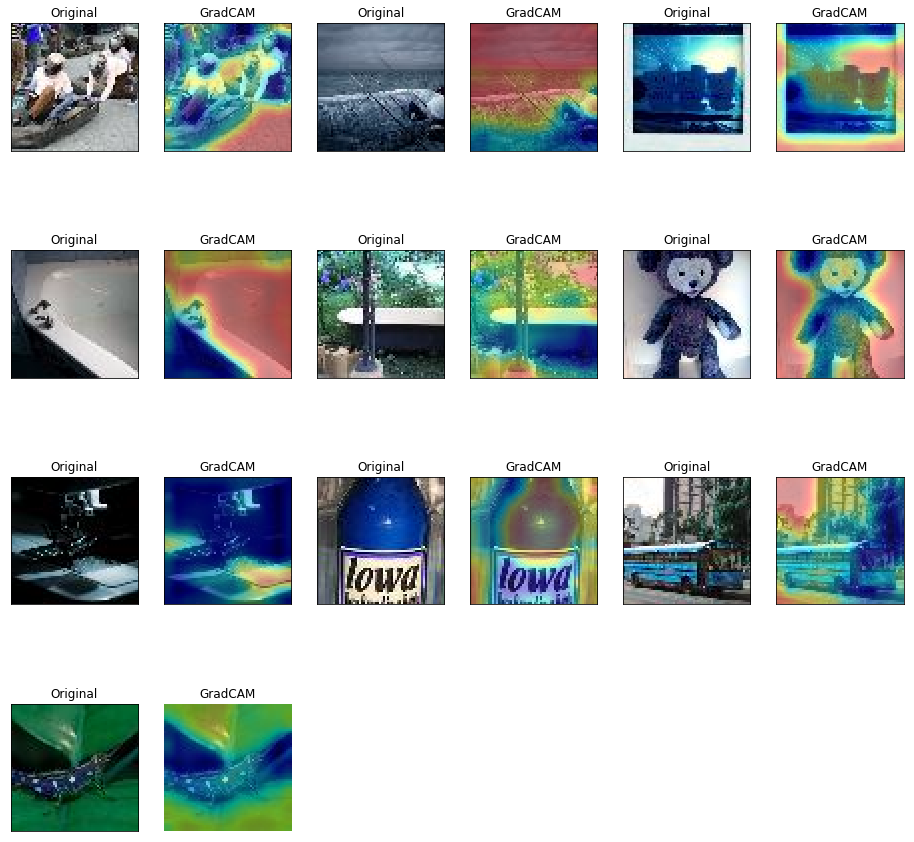

In [162]:
fig = plt.figure(figsize=(16,16))

for i in range(10):
  img_path = './tiny-imagenet-200/val/images/val_'+str(i)+'.JPEG'
  img = cv2.imread(img_path)
  ax = fig.add_subplot(4, 6, 2*i+1, xticks=[], yticks=[])
  ax.set_title('Original')
  plt.imshow(img)
  ax = fig.add_subplot(4, 6, 2*i+2, xticks=[], yticks=[])
  ax.set_title("GradCAM")
  superimposed=GradCam(img_path)
  plt.imshow(superimposed)
plt.axis('off')

### Gallary for 50 misclassified Image

(-0.5, 63.5, 63.5, -0.5)

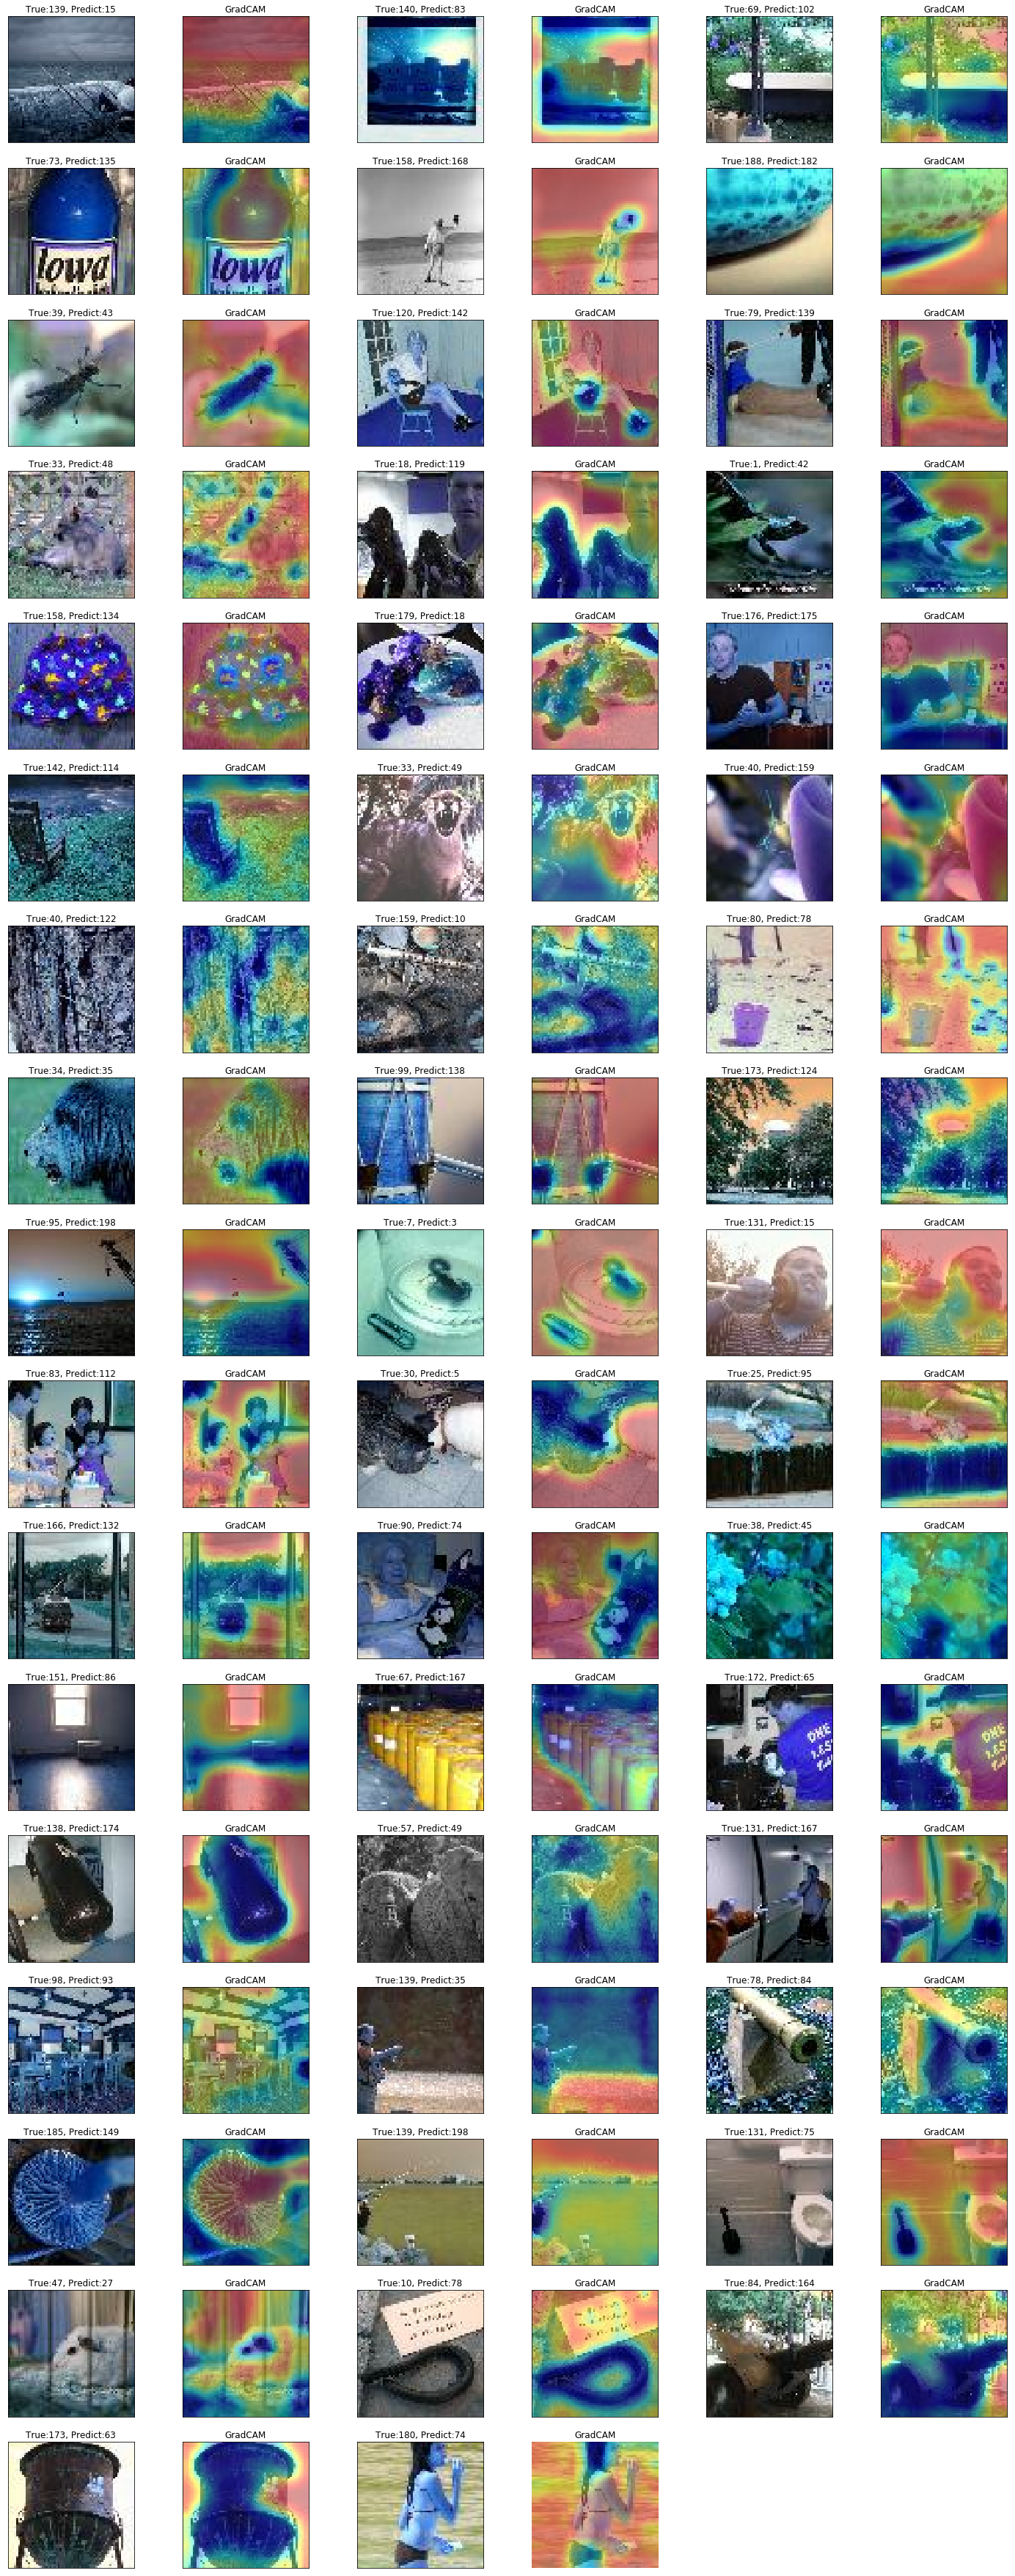

In [210]:
fig = plt.figure(figsize=(64,64))


for i in range(50):
  img_path = './tiny-imagenet-200/val/images/val_'+str(MisIndex[i])+'.JPEG'
  img = cv2.imread(img_path)
  ax = fig.add_subplot(17, 6, 2*i+1, xticks=[], yticks=[])
  ax.set_title('True:%s, Predict:%s' %(df.iloc[MisIndex[i]].true, df.iloc[MisIndex[i]].pred))
  plt.imshow(img)
  ax = fig.add_subplot(17, 6, 2*i+2, xticks=[], yticks=[])
  ax.set_title("GradCAM")
  superimposed=GradCam(img_path)
  plt.imshow(superimposed)
  plt.subplots_adjust(wspace=-0.9)
plt.axis('off')